<a href="https://colab.research.google.com/github/aleksejalex/DYNR1cv_2025/blob/main/cartpole_via_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pole balancing problem via Q-Learning
*Prepared by [Aleksej Gaj](https://aleksejgaj.cz)*

In [ ]:
%%capture
%pip install gymnasium
%pip install pygame

## Description (summary from [documentation page](https://gymnasium.farama.org/environments/classic_control/cart_pole/) )
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”.
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Action Space
The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

- **0**: Push cart to the left
- **1**: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

| Num | Observation          | Min    | Max    |
|-----|----------------------|--------|--------|
| 0   | Cart Position        | -4.8   | 4.8    |
| 1   | Cart Velocity        | -Inf   | Inf    |
| 2   | Pole Angle           | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf   | Inf    |

Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
- The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°).

### Rewards
Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

If `sutton_barto_reward=True`, then a reward of 0 is awarded for every non-terminating step and -1 for the terminating step. As a result, the reward threshold is 0 for v0 and v1.

### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05).

### Episode End
The episode ends if any one of the following occurs:

- **Termination**: Pole Angle is greater than ±12°
- **Termination**: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- **Truncation**: Episode length is greater than 500 (200 for v0)


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from gymnasium.wrappers import TimeLimit

In [2]:
max_steps = 800

In [3]:
# Create the environment
env = gym.make("CartPole-v1", render_mode=None)
env = env.unwrapped
env = TimeLimit(env, max_episode_steps = max_steps) # Re-wrap with custom max steps (e.g., 500)

# Discretization bins
NUM_BINS = (6, 12, 6, 12)  # Number of bins per observation dimension
NUM_BINS = (20, 12, 20, 12)

# Define observation space boundaries (manually clipped to reasonable limits)
OBS_SPACE_LOW = np.array([-2.4, -3.0, -0.21, -3.0])
OBS_SPACE_HIGH = np.array([2.4, 3.0, 0.21, 3.0])

#OBS_SPACE_LOW = np.array([-4.8, -3.0, -0.4, -3.0])
#OBS_SPACE_HIGH = np.array([4.8, 3.0, 0.4, 3.0])

### remark about discretizing continuous environment
The CartPole-v1 environment has a continuous observation space:
```python
obs = [cart position, cart velocity, pole angle, pole angular velocity]
```
Tabular Q-learning requires discrete states (e.g., integers you can use as dictionary keys), so we divide each dimension into bins.

#### What This Means:
- **6** → 6 bins for cart position (e.g., from left to right on the track)
- **12** → 12 bins for cart velocity
- **6** → 6 bins for pole angle (critical for balancing)
- **12** → 12 bins for pole angular velocity

This gives total possible discrete states = 6 × 12 × 6 × 12 = 5,184

That’s a manageable number for a Q-table (as opposed to infinitely many real-valued observations).

#### What can be tuned:
- **More bins** → finer resolution → more precision, but slower learning (larger Q-table).
- **Fewer bins** → faster learning, but coarser, potentially less stable control.

For example:

```python
NUM_BINS = (10, 10, 10, 10)  # More precise, but slower training  
NUM_BINS = (4, 6, 4, 6)      # Faster training, lower performance ceiling
```


In [4]:
# Discretize observation into bins
def discretize(obs):
    ratios = (obs - OBS_SPACE_LOW) / (OBS_SPACE_HIGH - OBS_SPACE_LOW)
    new_obs = (ratios * NUM_BINS).astype(int)
    new_obs = np.clip(new_obs, 0, np.array(NUM_BINS) - 1)
    return tuple(new_obs)

In [5]:
# Q-table initialized to zeros
q_table = defaultdict(lambda: np.zeros(env.action_space.n))
type(q_table)

collections.defaultdict

In [6]:
# Q-learning parameters
alpha = 0.4            # Learning rate, default: 0.1
gamma = 0.999          # Discount factor
epsilon = 1            # Exploration rate
epsilon_decay = 0.001
epsilon_min = 0.1
episodes = 9000
#max_steps = 200

In [7]:
# Tracking rewards
episode_rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    state = discretize(state)
    total_reward = 0

    for _ in range(max_steps):
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state_discrete = discretize(next_state)

        # Q-learning update
        best_next_action = np.max(q_table[next_state_discrete])
        td_target = reward + gamma * best_next_action
        td_delta = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_delta

        state = next_state_discrete
        total_reward += reward

        if done:
            break

    # Decay exploration
    #epsilon = max(epsilon * epsilon_decay, epsilon_min)
    epsilon_max = 1
    epsilon = (epsilon_max - epsilon_min)*np.exp(-epsilon_decay * episode)
    #epsilon = 0.1

    episode_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        avg = np.mean(episode_rewards[-100:])
        print(f"Episode {episode+1}/{episodes}: Average reward (last 100) = {avg:.2f}")

env.close()

Episode 100/9000: Average reward (last 100) = 23.68
Episode 200/9000: Average reward (last 100) = 24.83
Episode 300/9000: Average reward (last 100) = 30.38
Episode 400/9000: Average reward (last 100) = 32.09
Episode 500/9000: Average reward (last 100) = 36.74
Episode 600/9000: Average reward (last 100) = 39.92
Episode 700/9000: Average reward (last 100) = 51.43
Episode 800/9000: Average reward (last 100) = 57.62
Episode 900/9000: Average reward (last 100) = 79.41
Episode 1000/9000: Average reward (last 100) = 82.49
Episode 1100/9000: Average reward (last 100) = 104.48
Episode 1200/9000: Average reward (last 100) = 79.78
Episode 1300/9000: Average reward (last 100) = 84.80
Episode 1400/9000: Average reward (last 100) = 105.56
Episode 1500/9000: Average reward (last 100) = 124.99
Episode 1600/9000: Average reward (last 100) = 112.35
Episode 1700/9000: Average reward (last 100) = 103.43
Episode 1800/9000: Average reward (last 100) = 118.95
Episode 1900/9000: Average reward (last 100) = 14

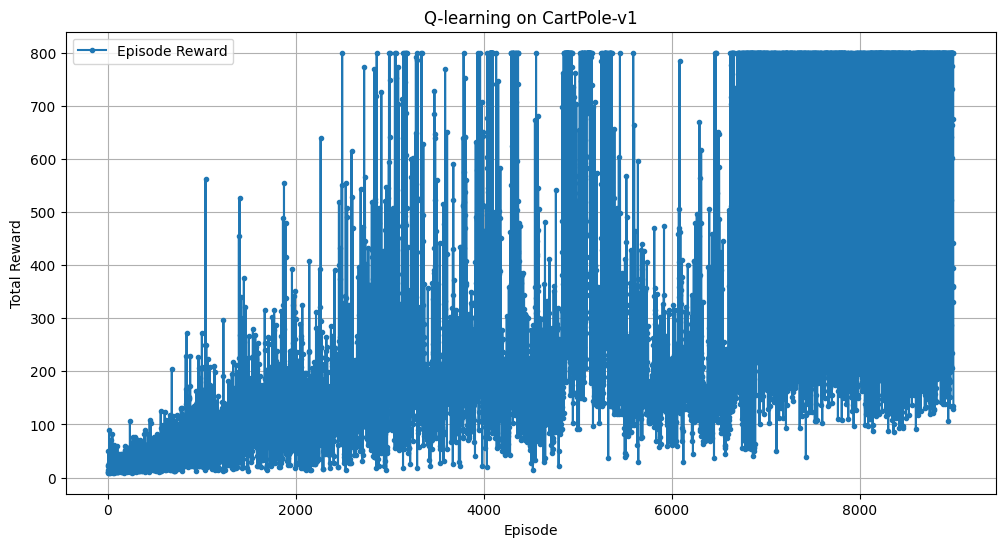

In [8]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label="Episode Reward", marker='.', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning on CartPole-v1")
plt.grid()
plt.legend()
plt.savefig(f"qlearing_episodes_{episodes}_maxsteps_{max_steps}.png", dpi=220)
plt.show()

## Plot via `pygame` (better if run locally)

In [ ]:
import time

In [ ]:
# Re-create environment in human render mode
env = gym.make("CartPole-v1", render_mode="human")  # render_mode="rgb_array" or render_mode="human"
env = env.unwrapped
env = TimeLimit(env, max_episode_steps = max_steps)

# Run a few episodes with the trained policy
num_eval_episodes = 4

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize(state)
    total_reward = 0
    done = False

    print(f"\n--- Evaluation Episode {ep+1} ---")

    while not done:
        action = np.argmax(q_table[state])  # Always choose the best action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = discretize(next_state)
        total_reward += reward
        time.sleep(0.05)  # Slow down for visualization

    print(f"Total Reward: {total_reward}")

env.close()


--- Evaluation Episode 1 ---
Total Reward: 167.0

--- Evaluation Episode 2 ---
Total Reward: 126.0

--- Evaluation Episode 3 ---
Total Reward: 284.0

--- Evaluation Episode 4 ---
Total Reward: 224.0


### How would random actions result?

In [ ]:
# Re-create environment in human render mode
env = gym.make("CartPole-v1", render_mode="human")  # render_mode="rgb_array" or render_mode="human"
env = env.unwrapped
env = TimeLimit(env, max_episode_steps=max_steps)

# Run a few episodes with random actions
num_eval_episodes = 4

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize(state)
    total_reward = 0
    done = False

    print(f"\n--- Evaluation Episode {ep + 1} ---")

    while not done:
        action = np.random.choice(env.action_space.n)  # Choose a random action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = discretize(next_state)
        total_reward += reward
        time.sleep(0.05)  # Slow down for visualization

    print(f"Total Reward: {total_reward}")

env.close()


--- Evaluation Episode 1 ---
Total Reward: 10.0

--- Evaluation Episode 2 ---
Total Reward: 22.0

--- Evaluation Episode 3 ---
Total Reward: 46.0

--- Evaluation Episode 4 ---
Total Reward: 26.0


## Plot via `matplotlib` and `Display` (see-able in jupyter notebook but not recommended)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

KeyboardInterrupt: 

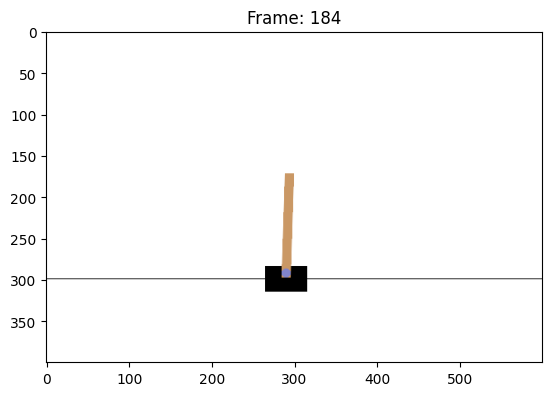

In [ ]:
# Assume q_table and discretize() are already defined
# max_steps is also assumed to be defined

env = gym.make("CartPole-v1", render_mode="rgb_array")  # use "rgb_array" for frame capture
env = env.unwrapped
env = TimeLimit(env, max_episode_steps=max_steps)

num_eval_episodes = 4

from IPython import display

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize(state)
    total_reward = 0
    done = False
    frame = 0

    print(f"\n--- Evaluation Episode {ep+1} ---")

    while not done:
        frame = frame + 1
        action = np.argmax(q_table[state])  # Choose best action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = discretize(next_state)
        total_reward += reward

        # Render the current frame and display it
        img=plt.imshow(env.render())
        plt.title(f"Frame: {frame}")
        plt.grid()
        display.display(plt.gcf())
        display.clear_output(wait=True)

    print(f"Total Reward: {total_reward}")
    frame = 0

env.close()

## Generating GIF instead of waiting for jupyter to display the frames...

In [10]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = env.unwrapped
env = TimeLimit(env, max_episode_steps=max_steps)  # or `max_steps` if defined

num_eval_episodes = 4
all_episode_frames = []  # Store all episodes' frames

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize(state)
    total_reward = 0
    done = False
    episode_frames = []

    print(f"\n--- Evaluation Episode {ep+1} ---")

    while not done:
        action = np.argmax(q_table[state])  # Choose best action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frame_rgb = env.render()
        episode_frames.append(frame_rgb)
        state = discretize(next_state)
        total_reward += reward

    print(f"Total Reward: {total_reward}")
    all_episode_frames.append(episode_frames)

env.close()


--- Evaluation Episode 1 ---
Total Reward: 205.0

--- Evaluation Episode 2 ---
Total Reward: 800.0

--- Evaluation Episode 3 ---
Total Reward: 460.0

--- Evaluation Episode 4 ---
Total Reward: 800.0


In [11]:
%pip install imageio

In [12]:
import imageio
import os

# Save each episode as a separate GIF
os.makedirs("gifs", exist_ok=True)

for ep_idx, frames in enumerate(all_episode_frames):
    gif_path = f"gifs/cartpole_episode_{ep_idx+1}.gif"
    imageio.mimsave(gif_path, frames, fps=30)
    print(f"Saved: {gif_path}")


Saved: gifs/cartpole_episode_1.gif
Saved: gifs/cartpole_episode_2.gif
Saved: gifs/cartpole_episode_3.gif
Saved: gifs/cartpole_episode_4.gif
